### 前馈神经网络模型
两种方式，一种是循环预测，一种是直接出N年

0.749 gene MAE

0.750 transplant MAE

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/es_with_decay.array'
transplant_arr_path = r'../output/transplant/es_with_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 10)
Shape of the transplant array: (5141, 17, 10)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 10)
Shape of the transplant array: (5141, 16, 10)


### 规范数据并获取训练集和测试集
这里的训练集、测试集和序列模型的不同，是滑动窗口

为了保证可比性，使用位置号来标明原来的序列

因为不是序列模型，所以需要展平多变量序列，也可以使用多个神经网络对每一维进行处理

此外，因为是多变量序列，所以模型要预测所有的变量，不然没法循环输入

https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

In [4]:
def to_supervised(data, n_inputs, ids_train, ids_test):
    train_data = data[ids_train]
    test_data = data[ids_test]
    
    X_train = list()
    X_test = list()
    y_train = list()
    y_test = list()
    
    for train in train_data:
        for i in range(len(train_data[0]) - n_inputs):
            X_train.append(train[i:i+n_inputs].flatten())
            y_train.append(train[i+n_inputs].flatten())
    
    for test in test_data:
        for i in range(len(test_data[0]) - n_inputs):
            X_test.append(test[i:i+n_inputs].flatten())
            y_test.append(test[i+n_inputs].flatten())
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [5]:
def split_data_by_es(data, data_ids):
    # 和RNN的不一样，这里用到ID
    total_es = np.sum(data[data_ids][:, :11, -2], axis=1)
    q75, q25 = np.percentile(total_es, [75 ,25])
    iqr = q75 - q25
    upper_bond = q75 + 1.5 * iqr
    lower_bond = q25 - 1.5 * iqr
    
    data_ids1 = []
    data_ids2 = []
    data_ids3 = []
    data_ids4 = []
    
    for data_id in data_ids:
        cur_es = np.sum(data[data_id][:11, -2])
        if cur_es > upper_bond:
            data_ids1.append(data_id)
        elif q75 < cur_es <= upper_bond:
            data_ids2.append(data_id)
        elif q25 < cur_es <= q75:
            data_ids3.append(data_id)
        elif cur_es <= q25:
            data_ids4.append(data_id)
        else:
            print('error')
    
    return data_ids1, data_ids2, data_ids3, data_ids4

In [16]:
# scaler, data = scale_data(gene_arr, 'standard')
scaler, data = scale_data(transplant_arr, 'standard')
X_train, X_test, y_train, y_test, ids_train, ids_test = split_data_with_index(data, n_input=11, ratio=0.2)

# 如果不是循环预测则不需要执行下面这一行
# X_train, X_test, y_train, y_test = to_supervised(data, 11, ids_train, ids_test)

In [17]:
train_data_ids1, train_data_ids2, train_data_ids3, train_data_ids4 = split_data_by_es(data, ids_train)
test_data_ids1, test_data_ids2, test_data_ids3, test_data_ids4 = split_data_by_es(data, ids_test)

X_train1, X_test1, y_train1, y_test1 = to_supervised(data, 11, train_data_ids1, test_data_ids1)
X_train2, X_test2, y_train2, y_test2 = to_supervised(data, 11, train_data_ids2, test_data_ids2)
X_train3, X_test3, y_train3, y_test3 = to_supervised(data, 11, train_data_ids3, test_data_ids3)
X_train4, X_test4, y_train4, y_test4 = to_supervised(data, 11, train_data_ids4, test_data_ids4)

### 构建模型

In [8]:
def build_recursive_dnn_model():
    model = keras.models.Sequential()
#     model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', input_shape=(X_train1.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(y_train1.shape[1]))
    model.compile(loss='mae', optimizer='rmsprop')
    return model

def build_direct_dnn_model():
    model = keras.models.Sequential()
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mae', optimizer='rmsprop')
    return model

def build_parallel_dnn_model(n_inputs, n_vars):
    var = []
    denses = []
    
    for i in range(n_vars):
        v = Input(shape=(n_inputs))
        d = Dense(256, activation='relu')(v)
        var.append(v)
        denses.append(d)
    
    merge = concatenate(denses)
    d_2 = Dense(128)(merge)
    output = Dense(5)(d_2)
    
    model = Model(inputs=var, outputs=output)
    model.compile(loss='mae', optimizer='rmsprop')
    
    return model

def build_parallel_X(data):
    Xs = []
    for i in range(data.shape[2]):
        Xs.append(data[:, :, i])
    return Xs

训练

In [18]:
train_xs = [X_train1, X_train2, X_train3, X_train4]
train_ys = [y_train1, y_train2, y_train3, y_train4]
test_xs = [X_test1, X_test2, X_test3, X_test4]
test_ys = [y_test1, y_test2, y_test3, y_test4]
i_s = [1, 2, 3, 4]

In [10]:
for train_x, train_y, test_x, test_y, i in zip(train_xs, train_ys, test_xs, test_ys, i_s):
    model = build_recursive_dnn_model()
    history = model.fit(train_x, train_y, epochs=100, batch_size=16, verbose=1, validation_data=(test_x, test_y), 
                   callbacks=[
                       ModelCheckpoint('mlp_model{}_checkpoint.h5'.format(i), save_best_only=True,verbose=1)
                   ])


Train on 1465 samples, validate on 410 samples
Epoch 1/100
1344/1465 [==========================>...] - ETA: 0s - loss: 1.0034
Epoch 00001: val_loss improved from inf to 0.68800, saving model to mlp_model1_checkpoint.h5
1465/1465 [==============================] - 1s 963us/sample - loss: 1.0094 - val_loss: 0.6880
Epoch 2/100
1328/1465 [==========================>...] - ETA: 0s - loss: 0.8598
Epoch 00002: val_loss improved from 0.68800 to 0.66588, saving model to mlp_model1_checkpoint.h5
1465/1465 [==============================] - 0s 214us/sample - loss: 0.8603 - val_loss: 0.6659
Epoch 3/100
1360/1465 [==========================>...] - ETA: 0s - loss: 0.8254
Epoch 00003: val_loss did not improve from 0.66588
1465/1465 [==============================] - 0s 199us/sample - loss: 0.8212 - val_loss: 0.6668
Epoch 4/100
1376/1465 [===========================>..] - ETA: 0s - loss: 0.8070
Epoch 00004: val_loss did not improve from 0.66588
1465/1465 [==============================] - 0s 230us/sa

Epoch 72/100
1248/1465 [========================>.....] - ETA: 0s - loss: 0.5194
Epoch 00072: val_loss did not improve from 0.63218
1465/1465 [==============================] - 0s 260us/sample - loss: 0.5146 - val_loss: 0.6846
Epoch 73/100
1424/1465 [============================>.] - ETA: 0s - loss: 0.5129
Epoch 00073: val_loss did not improve from 0.63218
1465/1465 [==============================] - 0s 240us/sample - loss: 0.5166 - val_loss: 0.6654
Epoch 74/100
1360/1465 [==========================>...] - ETA: 0s - loss: 0.5099
Epoch 00074: val_loss did not improve from 0.63218
1465/1465 [==============================] - 0s 259us/sample - loss: 0.5069 - val_loss: 0.6743
Epoch 75/100
1360/1465 [==========================>...] - ETA: 0s - loss: 0.5049
Epoch 00075: val_loss did not improve from 0.63218
1465/1465 [==============================] - 0s 251us/sample - loss: 0.5039 - val_loss: 0.6847
Epoch 76/100
1376/1465 [===========================>..] - ETA: 0s - loss: 0.4934
Epoch 00076

Epoch 44/100
3408/3675 [==========================>...] - ETA: 0s - loss: 0.2137
Epoch 00044: val_loss did not improve from 0.37688
3675/3675 [==============================] - 1s 233us/sample - loss: 0.2152 - val_loss: 0.3972
Epoch 45/100
3488/3675 [===========================>..] - ETA: 0s - loss: 0.2101
Epoch 00045: val_loss did not improve from 0.37688
3675/3675 [==============================] - 1s 229us/sample - loss: 0.2114 - val_loss: 0.3954
Epoch 46/100
3568/3675 [============================>.] - ETA: 0s - loss: 0.2121
Epoch 00046: val_loss did not improve from 0.37688
3675/3675 [==============================] - 1s 226us/sample - loss: 0.2123 - val_loss: 0.3959
Epoch 47/100
3536/3675 [===========================>..] - ETA: 0s - loss: 0.2129
Epoch 00047: val_loss did not improve from 0.37688
3675/3675 [==============================] - 1s 227us/sample - loss: 0.2132 - val_loss: 0.3943
Epoch 48/100
3520/3675 [===========================>..] - ETA: 0s - loss: 0.2096
Epoch 00048

3584/3675 [============================>.] - ETA: 0s - loss: 0.1829
Epoch 00080: val_loss did not improve from 0.37688
3675/3675 [==============================] - 1s 226us/sample - loss: 0.1824 - val_loss: 0.3938
Epoch 81/100
3504/3675 [===========================>..] - ETA: 0s - loss: 0.1837
Epoch 00081: val_loss did not improve from 0.37688
3675/3675 [==============================] - 1s 229us/sample - loss: 0.1832 - val_loss: 0.3933
Epoch 82/100
3552/3675 [===========================>..] - ETA: 0s - loss: 0.1822
Epoch 00082: val_loss did not improve from 0.37688
3675/3675 [==============================] - 1s 226us/sample - loss: 0.1823 - val_loss: 0.3959
Epoch 83/100
3536/3675 [===========================>..] - ETA: 0s - loss: 0.1822
Epoch 00083: val_loss did not improve from 0.37688
3675/3675 [==============================] - 1s 229us/sample - loss: 0.1822 - val_loss: 0.3973
Epoch 84/100
3568/3675 [============================>.] - ETA: 0s - loss: 0.1823
Epoch 00084: val_loss di

Epoch 15/100
10176/10275 [============================>.] - ETA: 0s - loss: 0.1562
Epoch 00015: val_loss did not improve from 0.18018
10275/10275 [==============================] - 2s 218us/sample - loss: 0.1562 - val_loss: 0.1840
Epoch 16/100
10128/10275 [============================>.] - ETA: 0s - loss: 0.1542
Epoch 00016: val_loss did not improve from 0.18018
10275/10275 [==============================] - 2s 228us/sample - loss: 0.1544 - val_loss: 0.1844
Epoch 17/100
10032/10275 [============================>.] - ETA: 0s - loss: 0.1535
Epoch 00017: val_loss did not improve from 0.18018
10275/10275 [==============================] - 2s 221us/sample - loss: 0.1526 - val_loss: 0.1815
Epoch 18/100
10160/10275 [============================>.] - ETA: 0s - loss: 0.1516
Epoch 00018: val_loss did not improve from 0.18018
10275/10275 [==============================] - 2s 219us/sample - loss: 0.1514 - val_loss: 0.1830
Epoch 19/100
10208/10275 [============================>.] - ETA: 0s - loss: 

Epoch 51/100
10112/10275 [============================>.] - ETA: 0s - loss: 0.1252
Epoch 00051: val_loss did not improve from 0.18018
10275/10275 [==============================] - 2s 220us/sample - loss: 0.1251 - val_loss: 0.1825
Epoch 52/100
10176/10275 [============================>.] - ETA: 0s - loss: 0.1249
Epoch 00052: val_loss did not improve from 0.18018
10275/10275 [==============================] - 2s 224us/sample - loss: 0.1252 - val_loss: 0.1839
Epoch 53/100
10096/10275 [============================>.] - ETA: 0s - loss: 0.1243
Epoch 00053: val_loss did not improve from 0.18018
10275/10275 [==============================] - 2s 222us/sample - loss: 0.1242 - val_loss: 0.1847
Epoch 54/100
10160/10275 [============================>.] - ETA: 0s - loss: 0.1244
Epoch 00054: val_loss did not improve from 0.18018
10275/10275 [==============================] - 2s 219us/sample - loss: 0.1244 - val_loss: 0.1835
Epoch 55/100
10240/10275 [============================>.] - ETA: 0s - loss: 

Epoch 87/100
10240/10275 [============================>.] - ETA: 0s - loss: 0.1140
Epoch 00087: val_loss did not improve from 0.18018
10275/10275 [==============================] - 3s 285us/sample - loss: 0.1142 - val_loss: 0.1851
Epoch 88/100
10256/10275 [============================>.] - ETA: 0s - loss: 0.1142
Epoch 00088: val_loss did not improve from 0.18018
10275/10275 [==============================] - 3s 287us/sample - loss: 0.1142 - val_loss: 0.1839
Epoch 89/100
10208/10275 [============================>.] - ETA: 0s - loss: 0.1136
Epoch 00089: val_loss did not improve from 0.18018
10275/10275 [==============================] - 3s 300us/sample - loss: 0.1138 - val_loss: 0.1827
Epoch 90/100
10160/10275 [============================>.] - ETA: 0s - loss: 0.1138
Epoch 00090: val_loss did not improve from 0.18018
10275/10275 [==============================] - 3s 289us/sample - loss: 0.1137 - val_loss: 0.1841
Epoch 91/100
10224/10275 [============================>.] - ETA: 0s - loss: 

4896/5145 [===========================>..] - ETA: 0s - loss: 0.1517
Epoch 00057: val_loss did not improve from 0.17841
5145/5145 [==============================] - 1s 224us/sample - loss: 0.1526 - val_loss: 0.1819
Epoch 58/100
4928/5145 [===========================>..] - ETA: 0s - loss: 0.1516
Epoch 00058: val_loss did not improve from 0.17841
5145/5145 [==============================] - 1s 238us/sample - loss: 0.1518 - val_loss: 0.1819
Epoch 59/100
5072/5145 [============================>.] - ETA: 0s - loss: 0.1526
Epoch 00059: val_loss did not improve from 0.17841
5145/5145 [==============================] - 1s 218us/sample - loss: 0.1517 - val_loss: 0.1819
Epoch 60/100
4944/5145 [===========================>..] - ETA: 0s - loss: 0.1536
Epoch 00060: val_loss did not improve from 0.17841
5145/5145 [==============================] - 1s 211us/sample - loss: 0.1526 - val_loss: 0.1799
Epoch 61/100
4960/5145 [===========================>..] - ETA: 0s - loss: 0.1505
Epoch 00061: val_loss di

预测

In [19]:
models = []
for i in range(1, 5):
    models.append(keras.models.load_model('trained_models/transplant_mlp/mlp_model{}_checkpoint.h5'.format(i)))

In [20]:
def recursive_predict(model, X_test, n_inputs, n_features, total_timesteps):
    # 只能用每个里面的第一部分，其他用预测来填充
    gap = total_timesteps - n_inputs
    y_pred = []
    i = 0
    while i < len(X_test):
        history = [num for num in X_test[i]]
        i += gap
        inner_pred = []
        for j in range(total_timesteps - n_inputs):
            X = np.array(history[-n_features * n_inputs:]).reshape(1, n_features * n_inputs)
            pred = list(model.predict(X)[0])
            inner_pred.append(pred[-2])
            history += pred
        y_pred.append(np.array(inner_pred))
    return np.array(y_pred)

In [21]:
y_preds = []
y_tests = []
for i in range(len(models)):
    y_preds.append(recursive_predict(models[i], test_xs[i], 11, 10, 16))
    y_tests.append(test_ys[i][:, -2].reshape(len(test_ys[i]) // 5, -1))
y_pred = np.concatenate(y_preds)
y_test = np.concatenate(y_tests)

In [22]:
y_test.shape

(1029, 5)

画图

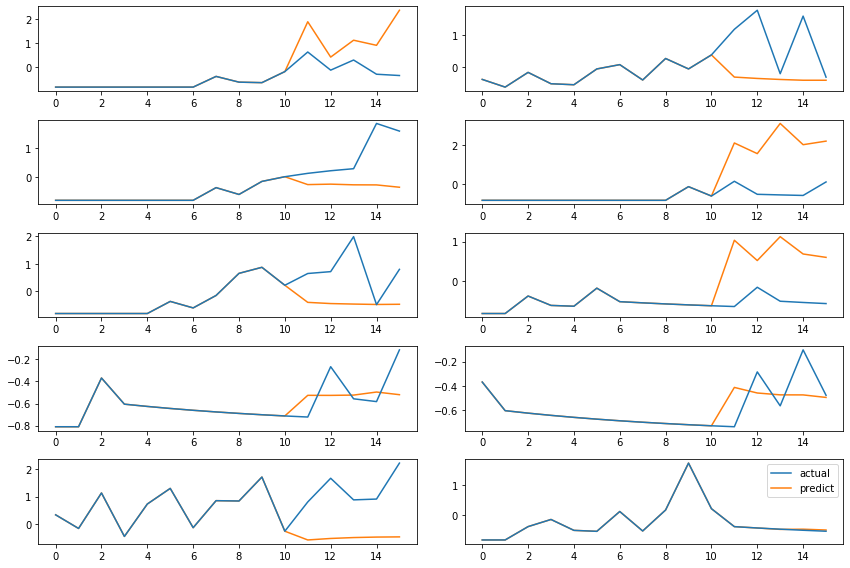

In [29]:
# 训练集
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_train[ids[i], :, -2], y_train[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_train[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

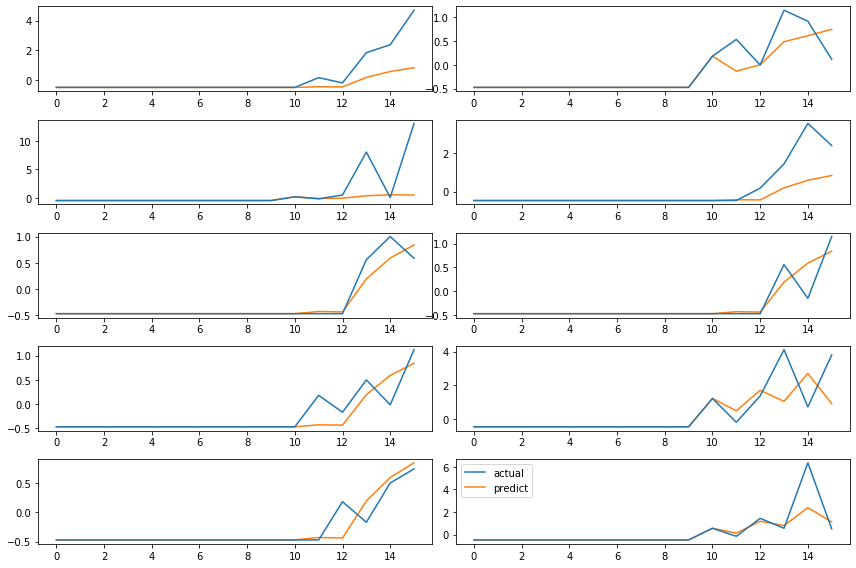

In [51]:
# 测试集
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_test[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

评估

MAE: 0.7499566986739405
MAE: [0.67298334 0.74516249 0.77515107 0.73237856 0.82410803]


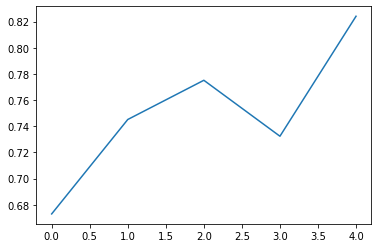

NDCG: 0.5443653208433433
NDCG: [0.14273109067437043, 0.0011046069625037817, 0.07215242347991342, 0.04079247692886313, 0.21164862789942854]


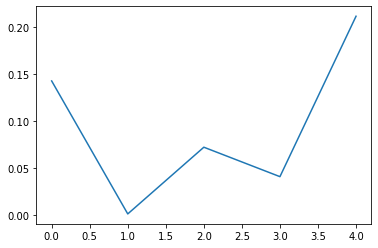

RMSE: 1.2173325753483577
RMSE: [1.1096555  1.26903701 1.23959492 1.1940331  1.26704069]


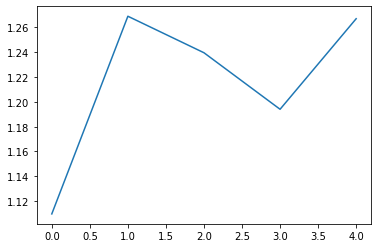

In [25]:
metrics = ['mae', 'ndcg' ,'rmse']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred, scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [32]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         1.0       0.86      0.86      0.86      3600
         2.0       0.33      0.33      0.33       770
         3.0       0.33      0.33      0.33       515
         4.0       0.40      0.40      0.40       260

    accuracy                           0.70      5145
   macro avg       0.48      0.48      0.48      5145
weighted avg       0.70      0.70      0.70      5145



In [34]:
errors = np.abs((y_test - y_pred) / y_test)
annual_mape = np.mean(errors, axis=0)
overall_mape = np.mean(errors, axis=None)
overall_mape

3.646415186256733